In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as ss
import scikit_posthocs as sp
from pingouin import friedman
import Orange
import seaborn as sns

ModuleNotFoundError: No module named 'bottleneck'

In [49]:
def construct_df_test(list_filename_open, performance_index):

    for num_result, filename_open in enumerate(list_filename_open):

        with open(filename_open, 'rb') as f:
            results_test = pickle.load(f)
            
        results_test_aux = {}
        
        for ind_set in list(results_test.keys()):
            results_test_aux[ind_set] = {}
            if 'test2_' in filename_open:
                results_test_aux[ind_set][list(results_test[1].keys())[0]] = results_test[ind_set][list(results_test[1].keys())[0]][performance_index]
            if 'test_' in filename_open:
                results_test_aux[ind_set][list(results_test[1].keys())[0]] = results_test[ind_set][list(results_test[1].keys())[0]]
            
        df_aux = pd.DataFrame(results_test_aux).T
        df_aux = df_aux.rename(columns={f'{df_aux.columns[0]}':f'{filename_open}'
                                        .replace('results_test_','')
                                        .replace('.pkl','')
                                        .replace(r'C:\Users\vhsm9\OneDrive\Área de Trabalho\Música\Python\Article_01','')})
        
        if num_result == 0:
            df_test = df_aux.copy()
        else:
            df_test = df_test.join(df_aux)
                        
    return df_test

In [50]:
def eval_test(df_test, num_datasets, friedman_plot=True):

    print(round(df_test.median()*100,2))
    print('\n')

    matrix_analysis = df_test.to_numpy()
    labels = list(df_test.columns)

    # Friedman Test
    
    if friedman_plot == True:  
        
        print('Friedman Test:\n')
        print('Option #1:')
        print(ss.friedmanchisquare(*matrix_analysis.T))

        print('\nOption #2:')
        
        df_matrix_analysis = pd.DataFrame(matrix_analysis, columns=labels)
        df_matrix_analysis['respID'] = range(1,len(df_matrix_analysis)+1)
        longDf = pd.melt(df_matrix_analysis, id_vars='respID', var_name='item', value_name='score')
        pgRes = friedman(data=longDf, dv='score', within='item', subject='respID')
        display(pgRes)

        # Post Hoc - Nemenyi Test (p-values):

        print('\nPost Hoc - Nemenyi (p-values):')
        pc = sp.posthoc_nemenyi_friedman(df_matrix_analysis.drop(['respID'],axis=1))
        display(pc)
        cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
        heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
        sp.sign_plot(pc, **heatmap_args)
        plt.show()


    # Average Rank + CD Diagram:

    rank_matrix = []

    for line in range(0, matrix_analysis.shape[0]):
        rank_matrix.append(ss.rankdata(-matrix_analysis[line,:]))

    rank_matrix = np.array(rank_matrix)
    avranks = rank_matrix.mean(axis=0)
    
    print(avranks)

    cd = Orange.evaluation.compute_CD(avranks,num_datasets,alpha='0.05', test='nemenyi') #tested on 100 experiments
    Orange.evaluation.graph_ranks(avranks, labels, cd=cd, width=10, textspace=1.5)
    print(f'CD Diagram (CD = {cd:.2f}):')
    #plt.savefig(r'C:\Users\vhsm9\OneDrive\Área de Trabalho\Figures\Neural_Computing\GTZAN_CDD.eps')
    plt.show()
    
    return

In [51]:
# Plot:

def plot_eval(df_test, labels, title, colors, performance_index):
    
    matrix_analysis = df_test.to_numpy()

    plt.figure(figsize=(15, 6))
    
    if performance_index == 'accuracy':
        
        bplot = plt.boxplot(100*matrix_analysis,
                            vert=True,  # vertical box alignment
                            patch_artist=True,  # fill with color
                            labels=labels)  # will be used to label x-ticks
        
        plt.ylabel('BACC$_a$ (%)', fontsize=15)
        
    elif performance_index == 'mean_accuracy':
        
        bplot = plt.boxplot(100*matrix_analysis,
                            vert=True,  # vertical box alignment
                            patch_artist=True,  # fill with color
                            labels=labels)  # will be used to label x-ticks
        
        plt.ylabel('MACC$_a$ (%)', fontsize=15)
    
    elif performance_index == 'fk':
        
        bplot = plt.boxplot(100*matrix_analysis,
                            vert=True,  # vertical box alignment
                            patch_artist=True,  # fill with color
                            labels=labels)  # will be used to label x-ticks
        
        plt.ylabel('Fk$_a$ (%)', fontsize=15)
        
    
    elif performance_index == 'fx':
        
        bplot = plt.boxplot(100*matrix_analysis,
                            vert=True,  # vertical box alignment
                            patch_artist=True,  # fill with color
                            labels=labels)  # will be used to label x-ticks
        
        plt.ylabel('Fx$_a$ (%)', fontsize=15)
        
        
        
    
    if 'f1_score' in performance_index:
        
        bplot = plt.boxplot(matrix_analysis,
                            vert=True,  # vertical box alignment
                            patch_artist=True,  # fill with color
                            labels=labels)  # will be used to label x-ticks
        
        if '_macro' in performance_index:
            plt.ylabel('F1-score (macro)', fontsize=15)
        
        if '_weighted' in performance_index:
            plt.ylabel('F1-score (weighted)', fontsize=15)
            
    if 'roc_auc' in performance_index:
        
        bplot = plt.boxplot(matrix_analysis,
                            vert=True,  # vertical box alignment
                            patch_artist=True,  # fill with color
                            labels=labels)  # will be used to label x-ticks
        
        if '_macro_ovr' in performance_index:
            plt.ylabel('ROC_AUC (macro_ovr)', fontsize=15)
        
        if '_weighted_ovr' in performance_index:
            plt.ylabel('ROC_AUC (weighted_ovr)', fontsize=15)

           
    plt.grid(axis='y')
    plt.xticks(fontsize=12) #14
    plt.yticks(fontsize=12) #14
    plt.yticks(np.arange(50, 100, step=5))
    plt.title(f'{title}', fontsize=14)
    plt.ylabel('BACC(%)', fontsize=12) #15
    plt.setp(bplot['medians'], color='black')

    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    plt.savefig('acc_fx8.jpg', bbox_inches = 'tight', transparent = True, pad_inches = 0.2)  
    plt.show()
    
    return

### Comparing:

results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx1    78.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx2    79.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx3    85.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx4    83.5
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx5    83.5
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx6    80.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx7    81.5
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx8    83.5
dtype: float64


Friedman Test:

Option #1:
FriedmanchisquareResult(statistic=41.13038130381304, pvalue=7.642438861727034e-07)

Option #2:


,Source,W,ddof1,Q,p-unc
Friedman,item,0.587577,7,41.130381,7.642439e-07



Post Hoc - Nemenyi (p-values):


,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx1,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx2,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx3,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx4,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx5,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx6,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx7,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx8
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx1,1.000000,0.751638,0.001000,0.001000,0.007510,0.860792,0.254294,0.002647
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx2,0.751638,1.000000,0.016754,0.138889,0.447819,0.900000,0.900000,0.278341
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx3,0.001000,0.016754,1.000000,0.900000,0.888080,0.008861,0.172514,0.900000
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx4,0.001000,0.138889,0.900000,1.000000,0.900000,0.087503,0.587906,0.900000
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx5,0.007510,0.447819,0.888080,0.900000,1.000000,0.329592,0.900000,0.900000
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx6,0.860792,0.900000,0.008861,0.087503,0.329592,1.000000,0.900000,0.190631
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx7,0.254294,0.900000,0.172514,0.587906,0.900000,0.900000,1.000000,0.778928
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx8,0.002647,0.278341,0.900000,0.900000,0.900000,0.190631,0.778928,1.000000


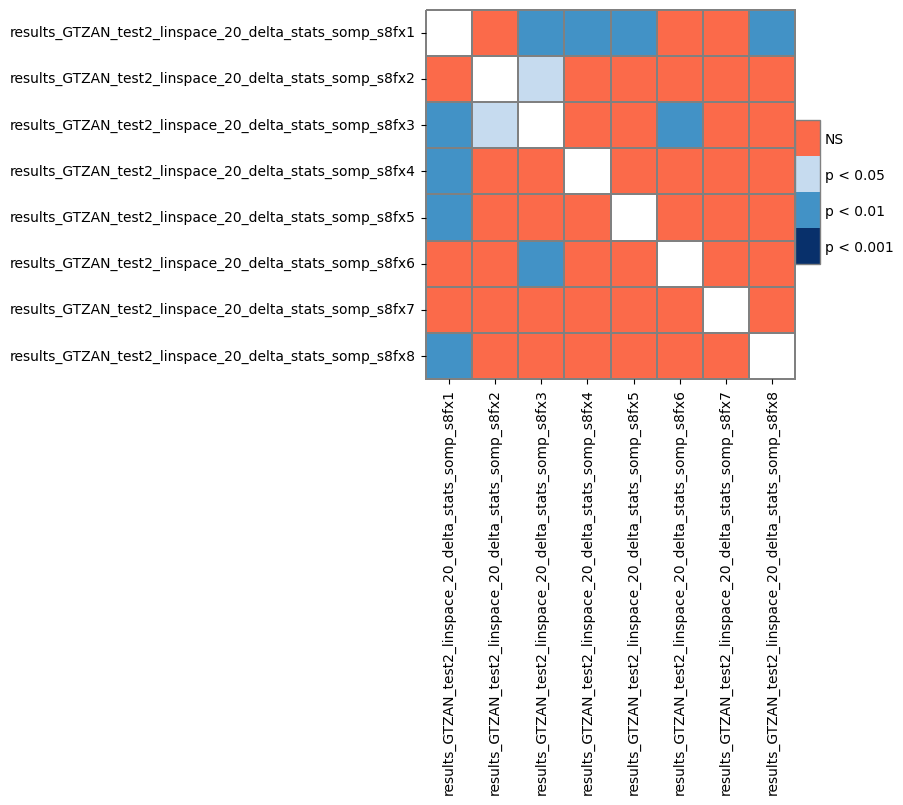

[7.5  5.8  2.1  2.9  3.55 6.   4.9  3.25]


NameError: name 'Orange' is not defined

In [53]:
# All classifiers - Texture Selector: LIN-20:

performance_index = 'accuracy'

list_filename_open9 = [r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp1.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp2.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp3.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp4.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp5.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp6.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp7.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp8.pkl',
    
                      
                      
                      


                      
                     
                     ]

df_test9 = construct_df_test(list_filename_open9, performance_index)

'''plot_eval(df_test,
          labels = ['GNB', 'LDA', 'QDA', r'$k$NN', 'MLR', 'SVM$_\mathrm{L}$', 'SVM$_\mathrm{R}$', 'RF', 'GB', 'MLP'],
          title = '',
          colors = ['pink', 'lightblue', 'lightgreen', 'orange', 'blue', 'green', 'yellow', 'purple', 'red'],
          performance_index = performance_index)'''

eval_test(df_test, 10, friedman_plot=True)

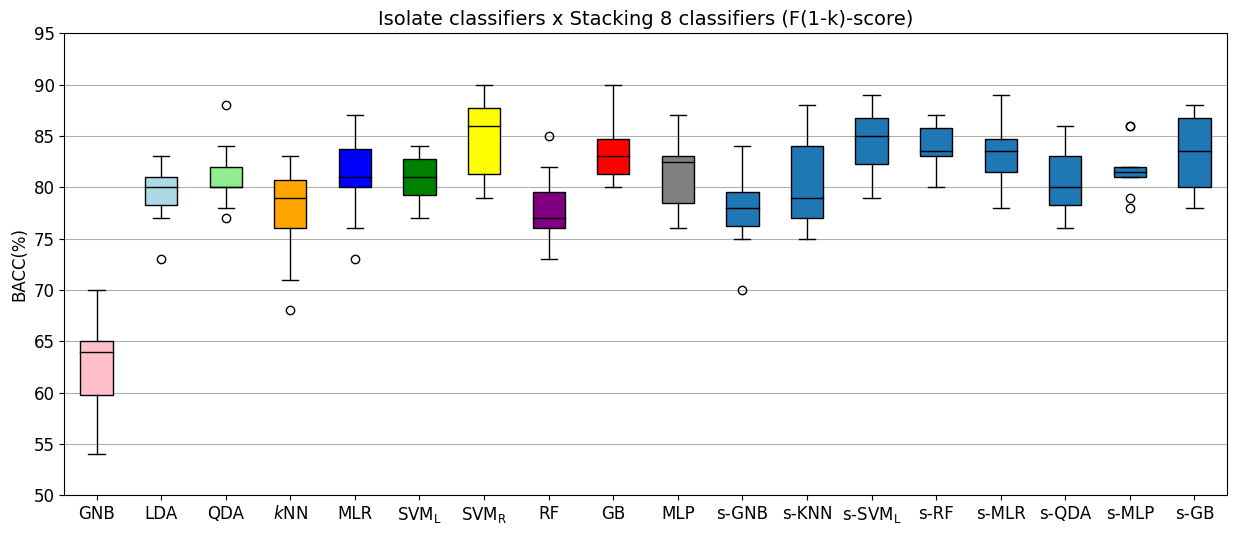

In [15]:
plot_eval(df_test,
          labels = ['GNB', 'LDA', 'QDA', r'$k$NN', 'MLR', 'SVM$_\mathrm{L}$', 'SVM$_\mathrm{R}$', 'RF', 'GB', 'MLP', 's-GNB', 's-KNN', 's-SVM$_\mathrm{L}$',
                   's-RF', 's-MLR', 's-QDA', 's-MLP', 's-GB']
                   ,
                   
          title = 'Isolate classifiers x Stacking 8 classifiers (F(1-k)-score)',
          colors = ['pink', 'lightblue', 'lightgreen', 'orange', 'blue', 'green', 'yellow', 'purple', 'red', 'grey'],
          performance_index ='accuracy')

In [22]:
df_test

,results_GTZAN_test2_linspace_20_delta_stats_somp_gnb,results_GTZAN_test2_linspace_20_delta_stats_somp_lda,results_GTZAN_test2_linspace_20_delta_stats_somp_qda,results_GTZAN_test2_linspace_20_delta_stats_somp_knn,results_GTZAN_test2_linspace_20_delta_stats_somp_logistic,results_GTZAN_test2_linspace_20_delta_stats_somp_svm-linear,results_GTZAN_test2_linspace_20_delta_stats_somp_svm,results_GTZAN_test2_linspace_20_delta_stats_somp_rf,results_GTZAN_test2_linspace_20_delta_stats_somp_lgboost,results_GTZAN_test2_linspace_20_delta_stats_somp_mlp,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx1,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx2,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx3,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx4,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx5,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx6,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx7,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx8
1,0.59,0.77,0.77,0.68,0.80,0.80,0.79,0.77,0.83,0.76,0.78,0.77,0.82,0.80,0.81,0.83,0.81,0.78
11,0.59,0.79,0.78,0.76,0.76,0.77,0.82,0.76,0.81,0.80,0.76,0.77,0.82,0.83,0.83,0.76,0.81,0.83
21,0.64,0.79,0.80,0.79,0.80,0.80,0.85,0.78,0.82,0.83,0.77,0.77,0.83,0.83,0.83,0.78,0.79,0.79
31,0.65,0.81,0.82,0.80,0.83,0.84,0.88,0.80,0.84,0.83,0.84,0.80,0.89,0.85,0.89,0.83,0.81,0.88
41,0.62,0.78,0.80,0.82,0.80,0.82,0.81,0.76,0.83,0.78,0.75,0.78,0.84,0.84,0.81,0.79,0.82,0.80
51,0.65,0.81,0.80,0.71,0.87,0.83,0.87,0.82,0.86,0.87,0.80,0.84,0.86,0.86,0.85,0.83,0.86,0.87
61,0.64,0.83,0.82,0.79,0.84,0.83,0.87,0.77,0.81,0.83,0.78,0.84,0.86,0.86,0.84,0.79,0.82,0.86
71,0.54,0.73,0.80,0.76,0.73,0.77,0.79,0.73,0.80,0.78,0.70,0.75,0.79,0.82,0.78,0.76,0.78,0.80
81,0.69,0.81,0.88,0.83,0.84,0.82,0.88,0.85,0.90,0.86,0.84,0.88,0.88,0.87,0.86,0.86,0.86,0.87
91,0.70,0.81,0.84,0.81,0.82,0.79,0.90,0.76,0.85,0.82,0.78,0.85,0.87,0.83,0.84,0.81,0.82,0.84


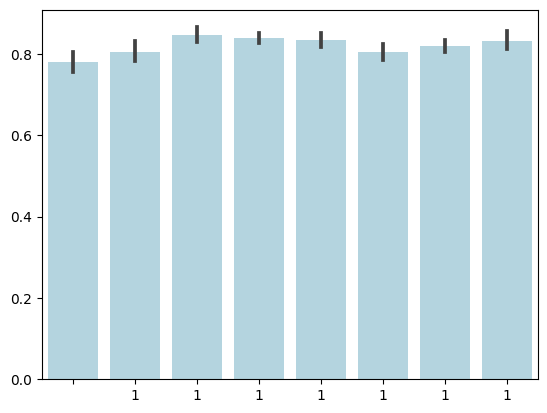

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.barplot(data = df_test, color = 'lightblue')

plt.xticks(np.arange(8), ['','1','1','1','1','1','1','1'])
plt.show()


In [84]:
print(round(df_test9.median()*100,2))

results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp1    84.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp2    84.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp3    84.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp4    79.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp5    82.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp6    82.5
results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp7    83.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8somp8    83.5
dtype: float64


In [120]:
s3fk = [82.5, 79.5, 83.5]
s5fk = [84, 84, 84.5,81.5,83]
s8fk = [84.5,83,84,81,82,84,84.5,79]

s3fx = [72.5, 79, 80]
s5fx = [77,79.5,84,83,84]
s8fx = [78,79,85,83.5,83.5,80,81.5,83.5]

s3somp = [83.5,80,83]
s5somp = [83,81.5,84,80,81]
s8somp = [84,84,84,79,82,82.5,83,83.5]


s3fk = pd.DataFrame(s3fk)
s5fk = pd.DataFrame(s5fk)
s8fk = pd.DataFrame(s8fk)

s3fx = pd.DataFrame(s3fx)
s5fx = pd.DataFrame(s5fx)
s8fk = pd.DataFrame(s8fx)

s3somp = pd.DataFrame(s3somp)
s5somp = pd.DataFrame(s5somp)
s8somp = pd.DataFrame(s8somp)

In [107]:
s3fk.columns = ['s-SVM','s-GB','s-MLP']

<AxesSubplot:>

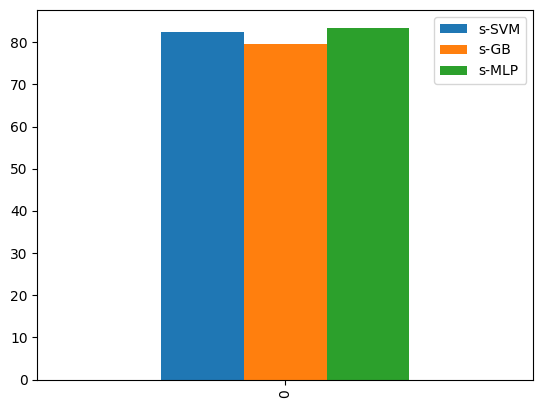

In [110]:
s3fk.plot.bar()

<AxesSubplot:>

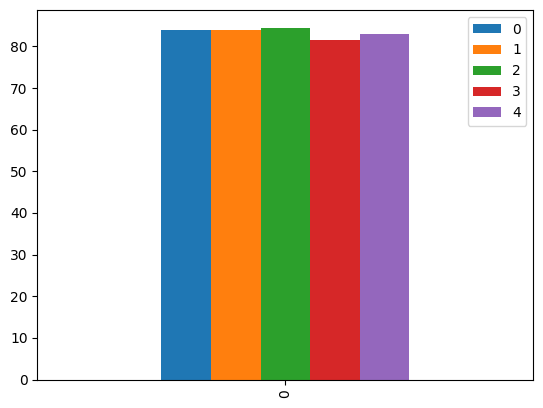

In [124]:
s5fk=s5fk.transpose()

s5fk.plot.bar()


<AxesSubplot:>

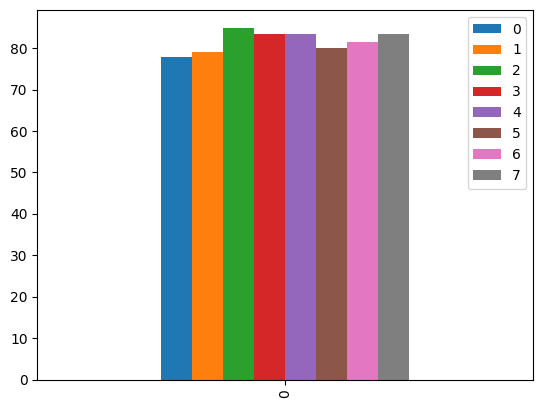

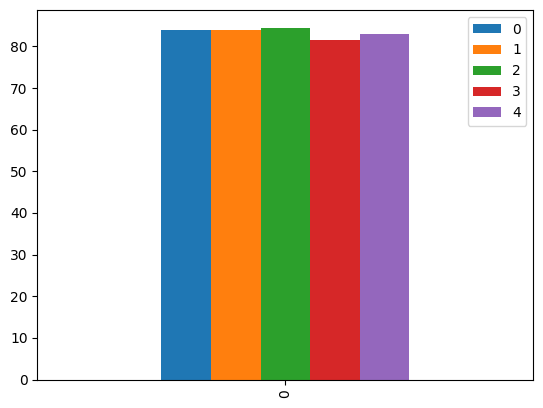

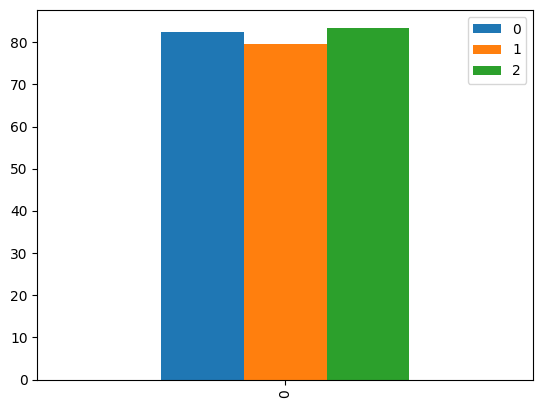

In [128]:
s3fk=s3fk.transpose()

s8fk.plot.bar()
s5fk.plot.bar()
s3fk.plot.bar()

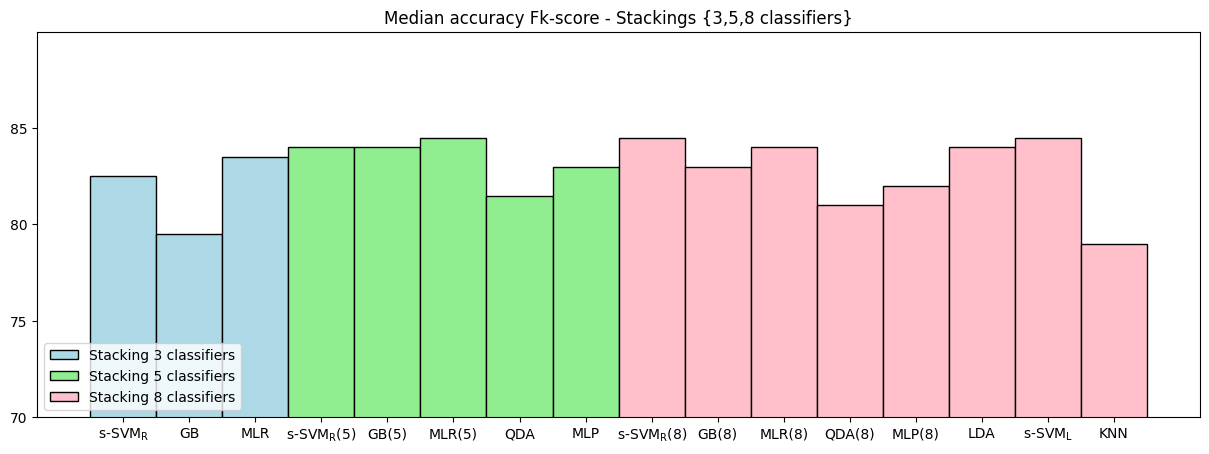

In [63]:
s3fk = [82.5, 79.5, 83.5]
s5fk = [84, 84, 84.5,81.5,83]
s8fk = [84.5,83,84,81,82,84,84.5,79]

plt.rcParams["figure.figsize"] = (15,5)
bar = 0.25

r1 = np.arange(len(s3fk))
r2 = [x + bar for x in np.arange(len(s3fk)+2)]
r2 = [x + bar for x in np.arange(len(s3fk)+5)]

plt.bar(['s-SVM$_\mathrm{R}$','GB','MLR'], s3fk, width = 1, label = 'Stacking 3 classifiers', edgecolor = 'black', color = 'lightblue')
plt.grid(False)
plt.yticks(np.arange(0, 90, 5))
plt.ylim(70, 90)
plt.bar(['s-SVM$_\mathrm{R}$(5)','GB(5)','MLR(5)', 'QDA','MLP'], s5fk, width = 1.0, color = 'lightgreen', edgecolor = 'black', label ='Stacking 5 classifiers')
plt.bar(['s-SVM$_\mathrm{R}$(8)','GB(8)','MLR(8)', 'QDA(8)','MLP(8)', 'LDA','s-SVM$_\mathrm{L}$','KNN'], s8fk, color = 'pink', width = 1.0, edgecolor = 'black', label ='Stacking 8 classifiers')
plt.legend(loc=3)
plt.title('Median accuracy Fk-score - Stackings {3,5,8 classifiers}')
plt.savefig('macc_fk.jpg')

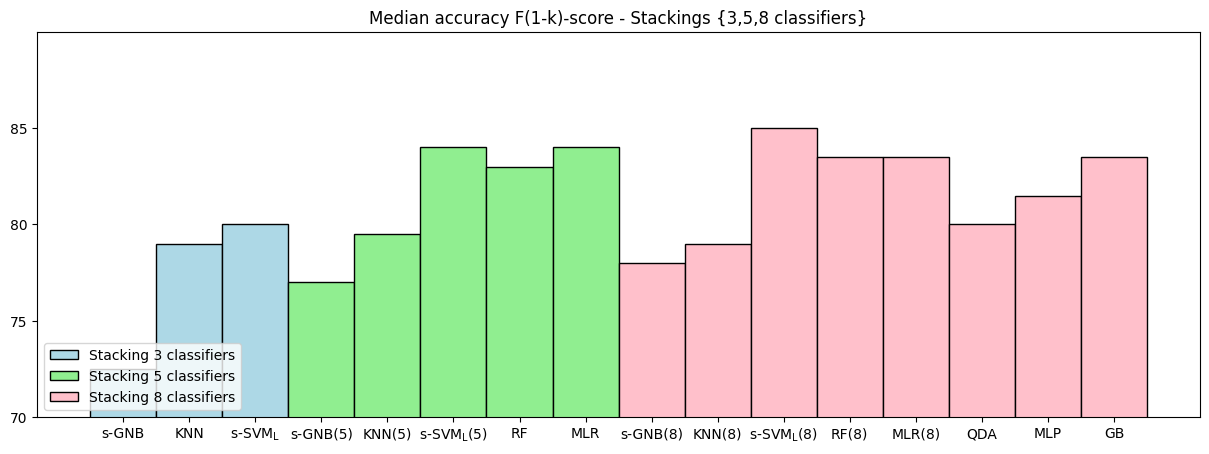

In [64]:
s3fx = [72.5, 79, 80]
s5fx = [77,79.5,84,83,84]
s8fx = [78,79,85,83.5,83.5,80,81.5,83.5]

plt.rcParams["figure.figsize"] = (15,5)
bar = 0.25



plt.bar(['s-GNB','KNN','s-SVM$_\mathrm{L}$'], s3fx, width = 1, label = 'Stacking 3 classifiers', edgecolor = 'black', color = 'lightblue')
plt.grid(False)
plt.yticks(np.arange(0, 90, 5))
plt.ylim(70, 90)
plt.bar(['s-GNB(5)','KNN(5)','s-SVM$_\mathrm{L}$(5)', 'RF','MLR'], s5fx, width = 1.0, color = 'lightgreen', edgecolor = 'black', label ='Stacking 5 classifiers')
plt.bar(['s-GNB(8)','KNN(8)','s-SVM$_\mathrm{L}$(8)', 'RF(8)','MLR(8)','QDA','MLP','GB'], s8fx, color = 'pink', width = 1.0, edgecolor = 'black', label ='Stacking 8 classifiers')
plt.legend(loc=3)
plt.title('Median accuracy F(1-k)-score - Stackings {3,5,8 classifiers}')
plt.savefig('macc_fx.jpg')

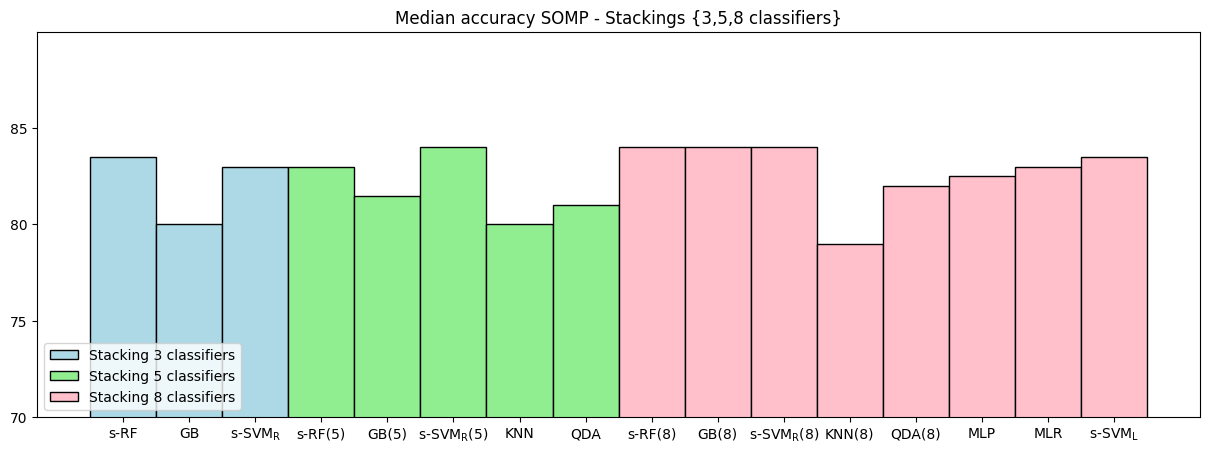

In [65]:
s3somp = [83.5,80,83]
s5somp = [83,81.5,84,80,81]
s8somp = [84,84,84,79,82,82.5,83,83.5]

plt.rcParams["figure.figsize"] = (15,5)
bar = 0.25



plt.bar(['s-RF','GB','s-SVM$_\mathrm{R}$'], s3somp, width = 1, label = 'Stacking 3 classifiers', edgecolor = 'black', color = 'lightblue')
plt.grid(False)
plt.yticks(np.arange(0, 90, 5))
plt.ylim(70, 90)
plt.bar(['s-RF(5)','GB(5)','s-SVM$_\mathrm{R}$(5)', 'KNN','QDA'], s5somp, width = 1.0, color = 'lightgreen', edgecolor = 'black', label ='Stacking 5 classifiers')
plt.bar(['s-RF(8)','GB(8)','s-SVM$_\mathrm{R}$(8)', 'KNN(8)','QDA(8)','MLP','MLR','s-SVM$_\mathrm{L}$'], s8somp, color = 'pink', width = 1.0, edgecolor = 'black', label ='Stacking 8 classifiers')
plt.legend(loc=3)
plt.title('Median accuracy SOMP - Stackings {3,5,8 classifiers}')
plt.savefig('macc_somp.jpg')

results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx1    72.5
results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx2    79.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx3    80.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx1    77.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx2    79.5
results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx3    84.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx4    83.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx5    84.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx1    78.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx2    79.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx3    85.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx4    83.5
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx5    83.5
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx6    80.0
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx7    81.5
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx8 

,Source,W,ddof1,Q,p-unc
Friedman,item,0.674899,15,101.234917,7.607602e-15



Post Hoc - Nemenyi (p-values):


,results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx1,results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx2,results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx3,results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx1,results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx2,results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx3,results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx4,results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx5,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx1,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx2,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx3,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx4,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx5,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx6,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx7,results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx8
results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx1,1.000000,0.900000,0.039591,0.900000,0.741329,0.001000,0.006574,0.001505,0.900000,0.107732,0.001000,0.001000,0.001000,0.258661,0.005988,0.001000
results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx2,0.900000,1.000000,0.900000,0.900000,0.900000,0.107732,0.619670,0.380357,0.900000,0.900000,0.001000,0.006574,0.042746,0.900000,0.604465,0.039591
results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx3,0.039591,0.900000,1.000000,0.330223,0.900000,0.900000,0.900000,0.900000,0.862985,0.900000,0.330223,0.665293,0.900000,0.900000,0.900000,0.900000
results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx1,0.900000,0.900000,0.330223,1.000000,0.900000,0.004506,0.100605,0.033851,0.900000,0.558840,0.001000,0.001000,0.001226,0.786952,0.093864,0.001102
results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx2,0.741329,0.900000,0.900000,0.900000,1.000000,0.272346,0.862985,0.634879,0.900000,0.900000,0.004091,0.026571,0.129619,0.900000,0.847781,0.123040
results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx3,0.001000,0.107732,0.900000,0.004506,0.272346,1.000000,0.900000,0.900000,0.077195,0.900000,0.900000,0.900000,0.900000,0.756535,0.900000,0.900000
results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx4,0.006574,0.619670,0.900000,0.100605,0.862985,0.900000,1.000000,0.900000,0.543634,0.900000,0.665293,0.900000,0.900000,0.900000,0.900000,0.900000
results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx5,0.001505,0.380357,0.900000,0.033851,0.634879,0.900000,0.900000,1.000000,0.300702,0.900000,0.893401,0.900000,0.900000,0.900000,0.900000,0.900000
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx1,0.900000,0.900000,0.862985,0.900000,0.900000,0.077195,0.543634,0.300702,1.000000,0.900000,0.001000,0.004091,0.028829,0.900000,0.528429,0.026571
results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx2,0.107732,0.900000,0.900000,0.558840,0.900000,0.900000,0.900000,0.900000,0.900000,1.000000,0.156760,0.449315,0.786952,0.900000,0.900000,0.771745


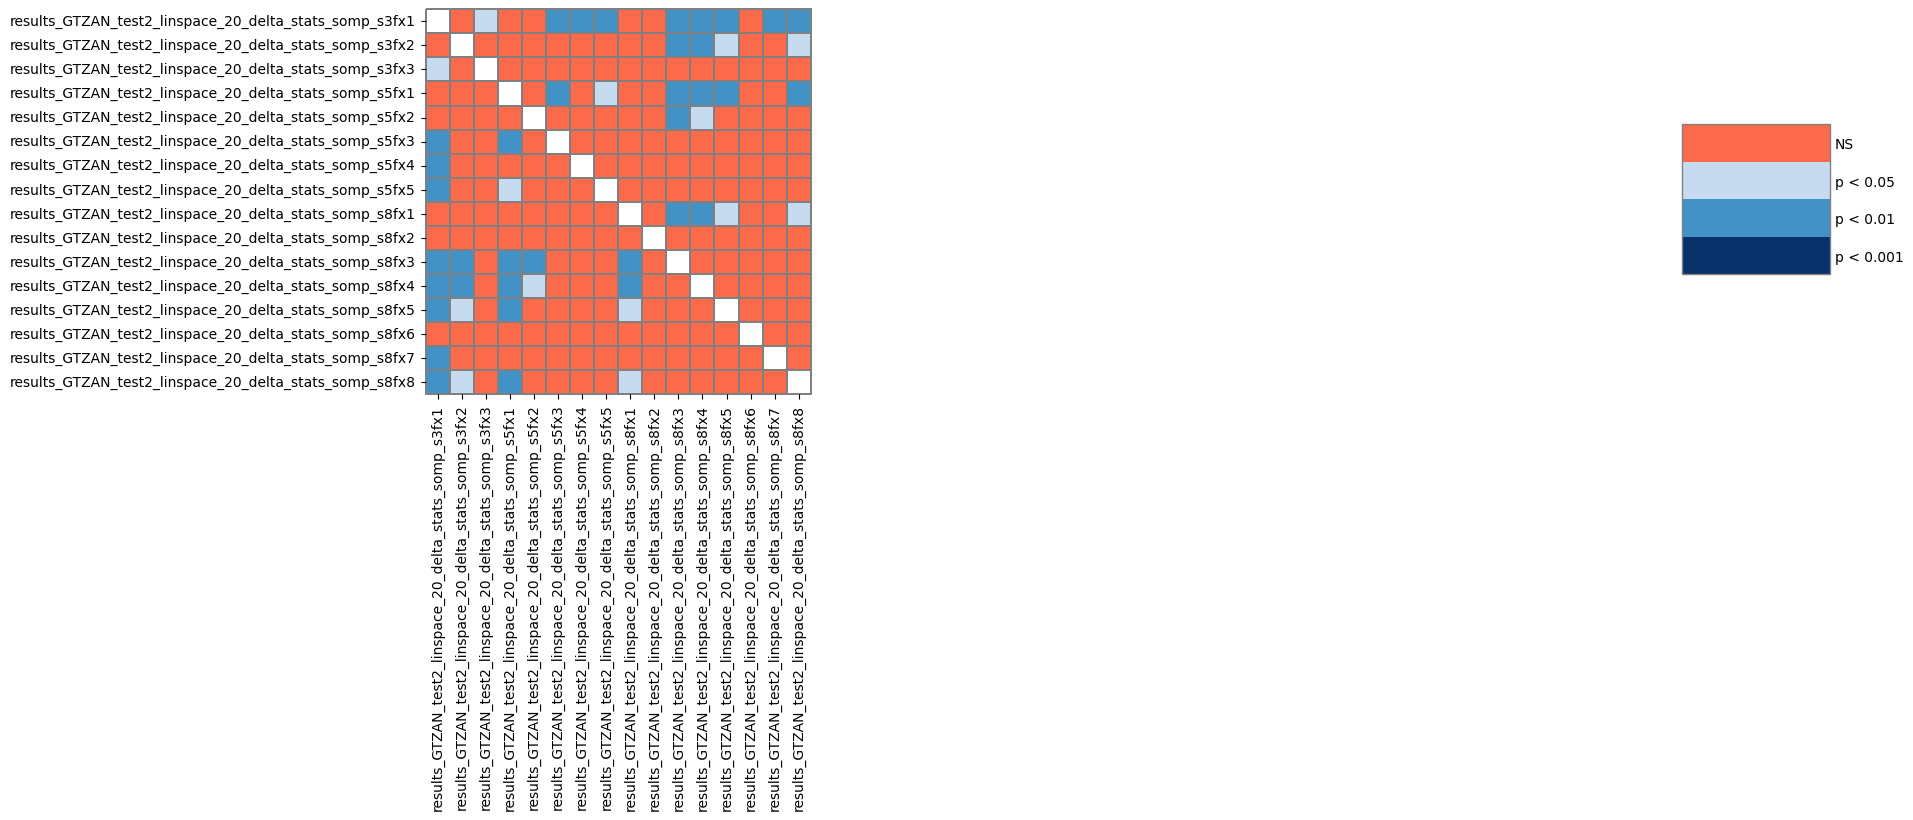

[15.85 12.2   8.4  14.15 11.4   5.45  7.35  6.6  12.45  9.1   2.65  3.7
  4.8   9.85  7.3   4.75]


NameError: name 'Orange' is not defined

In [53]:
performance_index = 'accuracy'

list_filename_open9 = [r'results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx1.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx2.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s3fx3.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx1.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx2.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx3.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx4.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s5fx5.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx1.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx2.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx3.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx4.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx5.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx6.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx7.pkl',
                      r'results_GTZAN_test2_linspace_20_delta_stats_somp_s8fx8.pkl',
    
                      
                      
                      


                      
                     
                     ]

df_test = construct_df_test(list_filename_open9, performance_index)

'''plot_eval(df_test,
          labels = ['GNB', 'LDA', 'QDA', r'$k$NN', 'MLR', 'SVM$_\mathrm{L}$', 'SVM$_\mathrm{R}$', 'RF', 'GB', 'MLP'],
          title = '',
          colors = ['pink', 'lightblue', 'lightgreen', 'orange', 'blue', 'green', 'yellow', 'purple', 'red'],
          performance_index = performance_index)'''

eval_test(df_test, 10, friedman_plot=True)

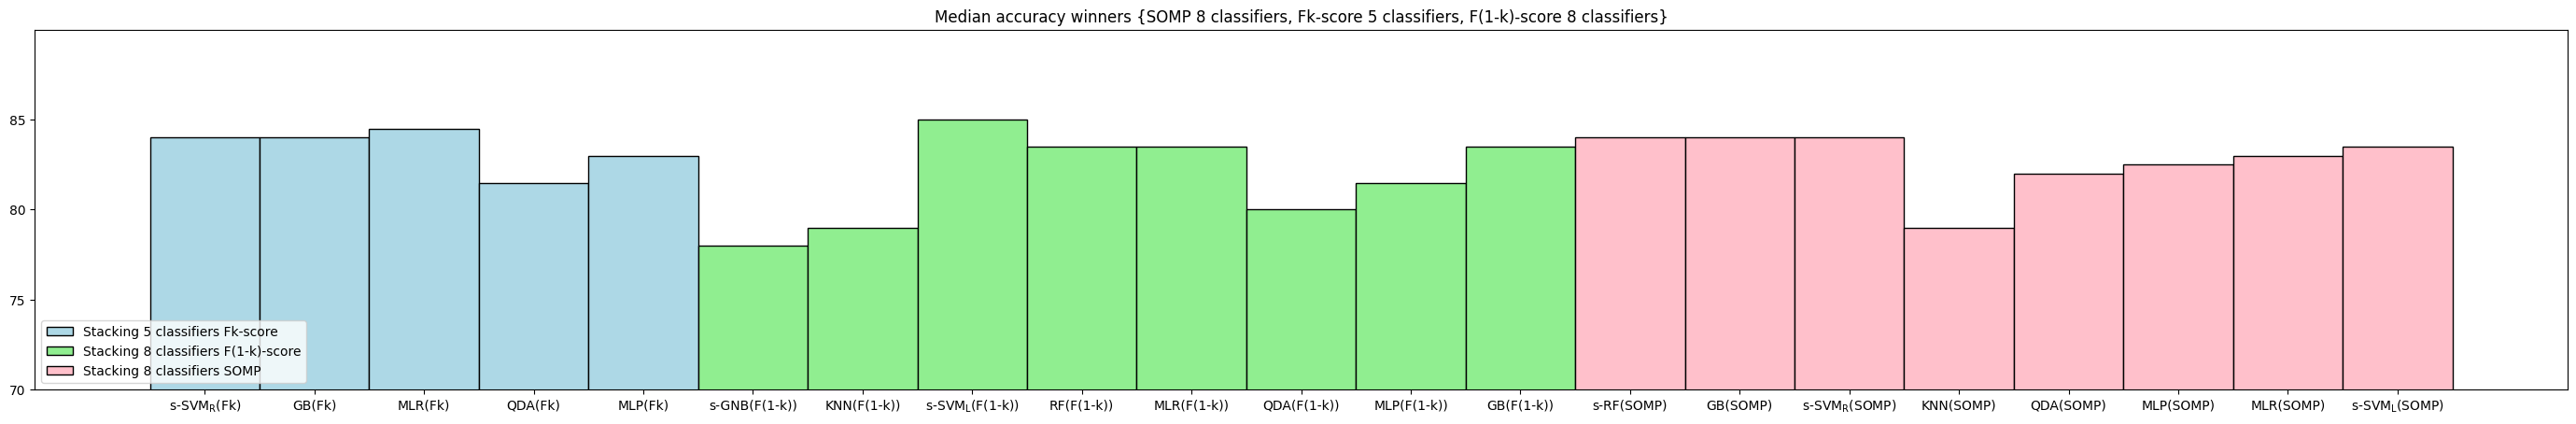

In [66]:
plt.rcParams["figure.figsize"] = (35,5)
bar = 0.25




plt.grid(False)
plt.yticks(np.arange(0, 90, 5))
plt.ylim(70, 90)


#fk
plt.bar(['s-SVM$_\mathrm{R}$(Fk)','GB(Fk)','MLR(Fk)', 'QDA(Fk)','MLP(Fk)'], s5fk, width = 1.0, color = 'lightblue', edgecolor = 'black', label ='Stacking 5 classifiers Fk-score')
#fx
plt.bar(['s-GNB(F(1-k))','KNN(F(1-k))','s-SVM$_\mathrm{L}$(F(1-k))', 'RF(F(1-k))','MLR(F(1-k))','QDA(F(1-k))','MLP(F(1-k))','GB(F(1-k))'], s8fx, color = 'lightgreen', width = 1.0, edgecolor = 'black', label ='Stacking 8 classifiers F(1-k)-score')
#somp
plt.bar(['s-RF(SOMP)','GB(SOMP)','s-SVM$_\mathrm{R}$(SOMP)', 'KNN(SOMP)','QDA(SOMP)','MLP(SOMP)','MLR(SOMP)','s-SVM$_\mathrm{L}$(SOMP)'], s8somp, color = 'pink', width = 1.0, edgecolor = 'black', label ='Stacking 8 classifiers SOMP')

plt.legend(loc=3)

plt.title('Median accuracy winners {SOMP 8 classifiers, Fk-score 5 classifiers, F(1-k)-score 8 classifiers}')
plt.savefig('macc_all.jpg')



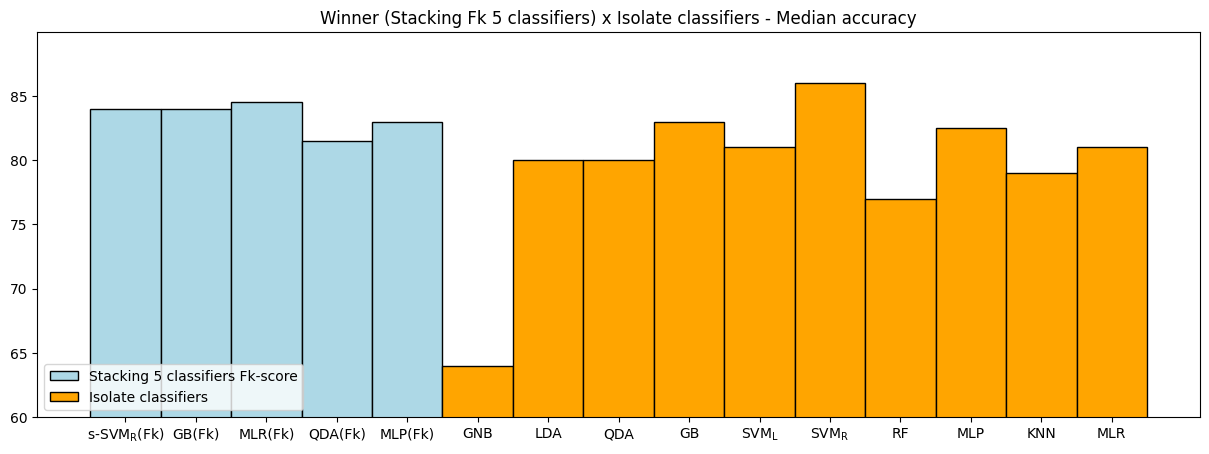

In [114]:
plt.rcParams["figure.figsize"] = (15,5)
bar = 0.25
isolates =[64,80,80,83,81,86,77,82.5,79,81]





plt.grid(False)
plt.yticks(np.arange(0, 90, 5))
plt.ylim(60, 90)

#fk
plt.bar(['s-SVM$_\mathrm{R}$(Fk)','GB(Fk)','MLR(Fk)', 'QDA(Fk)','MLP(Fk)'], s5fk, width = 1.0, color = 'lightblue', edgecolor = 'black', label ='Stacking 5 classifiers Fk-score')


plt.legend(loc=3)
plt.title('Median accuracy winners {SOMP 8 classifiers, Fk-score 5 classifiers, F(1-k)-score 8 classifiers}')



plt.bar(['GNB', 'LDA', 'QDA','GB', 'SVM$_\mathrm{L}$','SVM$_\mathrm{R}$','RF','MLP','KNN','MLR' ], isolates, color = 'orange', width = 1.0, edgecolor = 'black', label ='Isolate classifiers')

plt.legend(loc=3)
plt.title('Winner (Stacking Fk 5 classifiers) x Isolate classifiers - Median accuracy')
plt.savefig('compare_isolate.jpg')

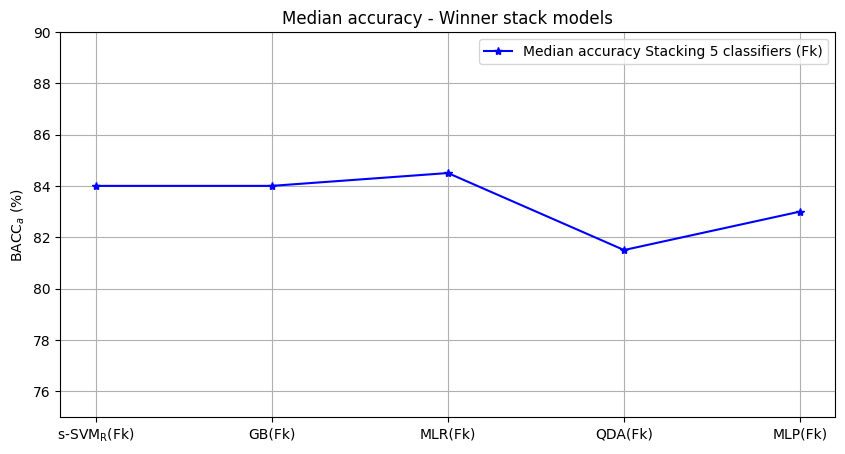

In [105]:
#s5fk

#s8fx

#s8somp
plt.rcParams["figure.figsize"] = (10,5)

label_f5fk= ['s-SVM$_\mathrm{R}$(Fk)','GB(Fk)','MLR(Fk)', 'QDA(Fk)','MLP(Fk)']
#fx
label_f8fx= ['s-GNB(F(1-k))','KNN(F(1-k))','s-SVM$_\mathrm{L}$(F(1-k))', 'RF(F(1-k))','MLR(F(1-k))','QDA(F(1-k))','MLP(F(1-k))','GB(F(1-k))']
#somp
label_f8somp= ['s-RF(SOMP)','GB(SOMP)','s-SVM$_\mathrm{R}$(SOMP)', 'KNN(SOMP)','QDA(SOMP)','MLP(SOMP)','MLR(SOMP)','s-SVM$_\mathrm{L}$(SOMP)']

plt.plot(label_f5fk, s5fk, marker = "*", label = 'Median accuracy Stacking 5 classifiers (Fk)', color = 'blue')
plt.ylim(75, 90)
plt.grid(True)
plt.title('Median accuracy - Winner stack models')
plt.ylabel('BACC$_a$ (%)')
plt.legend(loc='best')
plt.savefig('vencedor_fk.jpg')

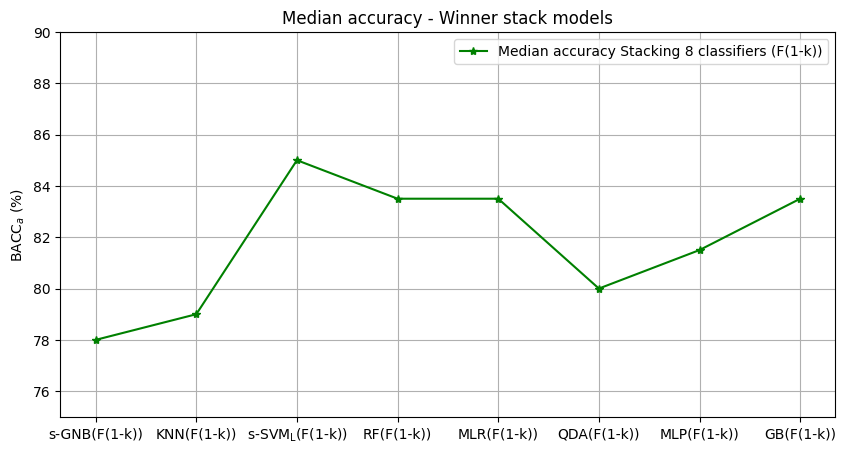

In [106]:
plt.grid(True)
plt.title('Median accuracy - Winner stack models')
plt.ylabel('BACC$_a$ (%)')
plt.ylim(75, 90)

plt.plot(label_f8fx, s8fx,marker = "*", label = 'Median accuracy Stacking 8 classifiers (F(1-k))', color = 'green')
plt.legend(loc='best')
plt.savefig('vencedor_fx.jpg')

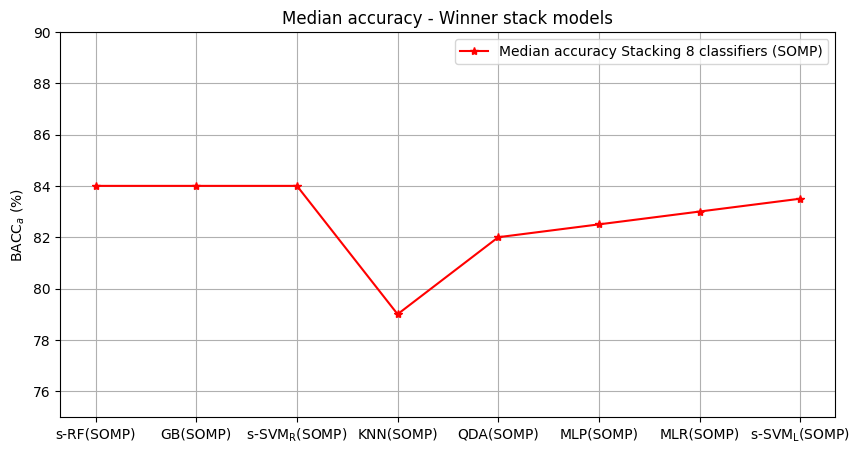

In [107]:
plt.grid(True)
plt.title('Median accuracy - Winner stack models')
plt.ylabel('BACC$_a$ (%)')
plt.ylim(75, 90)

plt.plot(label_f8somp, s8somp,marker = "*", label = 'Median accuracy Stacking 8 classifiers (SOMP)', color = 'red')
plt.legend(loc='best')
plt.savefig('vencedor_somp.jpg')

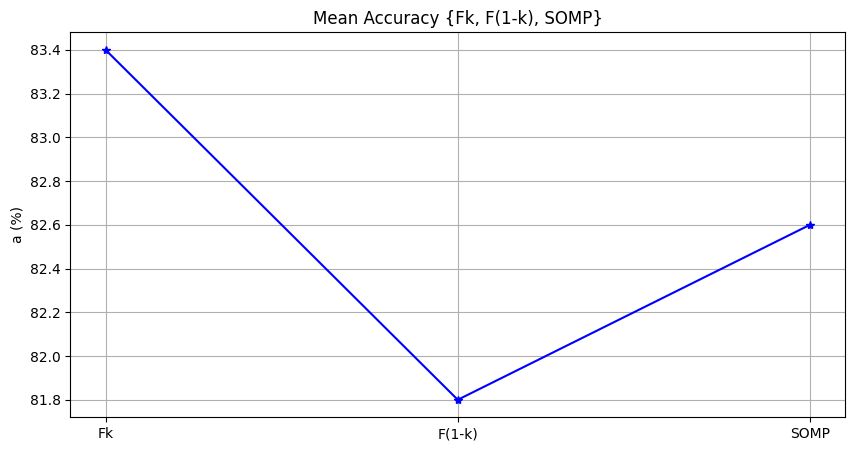

In [108]:
metodos = ['Fk', 'F(1-k)', 'SOMP']
RESULTS = [83.4 ,81.8, 82.6]
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(True)
plt.title('Mean Accuracy {Fk, F(1-k), SOMP}')
plt.plot(metodos, RESULTS, marker = "*", label = 'Median accuracy {Fk, F(1-k), SOMP}', color = 'blue')
plt.ylabel('a (%)')
plt.savefig('mean.jpg')

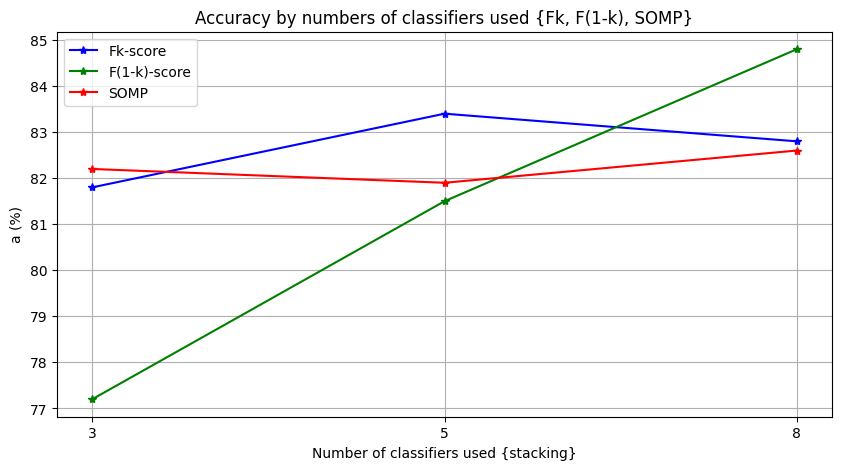

In [119]:
indices = ['3', '5', '8']
fk = [81.8,83.4,82.8]
fx = [77.2,81.5,84.8]
somp = [82.2,81.9,82.6]
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(True)
plt.title('Accuracy by numbers of classifiers used {Fk, F(1-k), SOMP}')
plt.plot(indices, fk, marker = "*", label = 'Fk-score', color = 'blue')
plt.plot(indices, fx, marker = "*", label = 'F(1-k)-score', color = 'green')
plt.plot(indices, somp, marker = "*", label = 'SOMP', color = 'red')
plt.ylabel('a (%)')
plt.xlabel('Number of classifiers used {stacking}')
plt.legend(loc = 'best')
plt.savefig('n_class.jpg')